# Barske Pump Design

> Author: Craig Orrock (assisted by Elias Aoubala)

> Date: 24/05/2025

In [1]:
import numpy as np
from turborocket.sizing.pump import Barske, DiffuserType
from turborocket.fluids.fluids import IncompressibleFluid
import matplotlib.pyplot as plt

import handcalcs.render

## 1 - Background

This document contains the sizing of the Barske Impeller pump using the turborocket pump class built by `Craig Orrock`.

## 2 - High Level Performance Metrics and Assumptions

Below, a dictionary of the high level performance metrics for the pump has been presented. The design methodology follows the recommendations presented by `U.M. Barske` in his publication `The Design of Open Impeller Centrifugal Pumps`.

A standard flat sided impeller has been assumed for the present geometry, moreover a rectangular diffuser is intended to be used.

Given the small flow rates we will be dealing, inorder for the pump geometry to be feasible to manufacture, the pump will be sized for a larger than required mass flow rate with a recirculation valve used to recirculate any excess mass flow back round to the inlet of the pump.

A diagram has been presented below of what the architecture would look like:

```mermaid
flowchart LR

    inlet("Inlet") --> JN1{"Junction 1"}
    JN1 --> pump["Barske Pump"]

    pump --> JN2{"Junction 2"}

    JN2 --> engine(["Main Engine"])

    JN2 --> GG(["Gas Generator"])

    JN2 --> valve{{"Needle Valve 1"}}

    valve --> JN1

```

Now there are four key things that drive the sizing of the pump and the needle valve:

- COTS component availability for the needle valve
- Gas Generator Sizing for the required pump power
- Main Engine Expected Propellant Flow Ranges for the Pump
- Required **Operational Run-Time**.

The first three problems are relatively easy to resolve, however the last of the three is most problematic as doing the recirculation loop will result in a rise in temperature over time of the propellant entering the pump which could eventually result in a cavitation event.

Thus, it is critical to understand what the expected temperature rise would be by implementing this recirculation valve accordingly and evaluate what the expected impact would be on system performance.

### 2.1 - Recirculation Temperature Increase Rate

For evaluating the Temperature Increase Rate of the pump, we need to firstly evaluate for what the waste-power is relative to the flow rate which could generate heat.

We know that the hydraulic efficiency of a pump can be defined as follows:

$$\eta = \frac{P_{a}}{P_{theo}}$$

Where $P_a$ refers to the actual hydraulic power of the pump and $P_{theo}$ refers to the theoretical power of the pump. We can take the conservative assumption and assume that all the "lost" power is imparted as heat directy into the fluid, resulting in a temperature rise accordingly.

Hence we can define the thermal power added to the fluid as follows:

$$P_{th} = P_{theo} - P_{a}$$

$$P_{th} = P_{theo}(1 - \eta)$$

The temperature rise in a fluid caused by an addition of thermal energy is as follows:

$$E = m c_p \Delta T$$

We can convert this to a time dependent form by differentiating with respect to time to get the following:

$$P_{th} = \dot{m} c_p \Delta T$$

This will now give us an idea of the temperature rise that results from the efficiency losses of the impeller.

We must now also account for the mixing of propellant at the inlet of the pump between the recirculated fluid and the delivered fluid from the test-house using a conservation of energy approach to get the following:

$$T_f = \frac{\dot{m}_1 T_1 + \dot{m}_2 T_2}{\dot{m}_1 + \dot{m}_2}$$

$$T_f = \frac{\dot{m}_1 T_1 + \dot{m}_2 T_2}{\dot{m}_{pump}}$$

We can introduce a "recirculation factor" to get the following:

$$T_f = (1- \chi)T_1 + \chi T_2$$

Where $\chi$ refers to the percentage of the total pump flow that is recirculated back into the pump inlet.

Remembering T_2 is just the previous temperature time step with the addition of the thermal energy, we get the following:

$$T_{i} = (1- \chi)T_1 + \chi (T_{i-1} + \Delta T)$$

Which if we substitude our parameters, we can get the following

$$T_{i} = (1- \chi)T_1 + \chi (T_{i-1} + \frac{P_{theo}(1 - \eta)}{\dot{m}_{pump} c_p} )$$

We can also substitude our definition for the theoretical power produced by the pump as follows:

$$P_{theo} = Q \Delta P = \frac{\dot{m}_{pump}}{\rho} \Delta P$$

This gives us the following expression:

$$T_{i} = (1- \chi)T_1 + \chi (T_{i-1} + \frac{\Delta P(1 - \eta)}{\rho c_p} )$$

This will result in the following equation

$$T(t) = T_{steady} + (T_{o} - T_{steady}) e^{- \frac{\dot{m}_i}{m} t}$$

Where the steady temperature is defined as the following

$$T_{steady} = T_{in} + \frac{\Delta P(1 - \eta)}{\chi \rho c_p}$$

We now have a simple equation we can integrate over time to see what our temperature rise would be for a given dp and efficiency. For this analysis, a conservative value of 10% will be assumed on efficiency.

m_dot_v: 233.15 g/s
0.09868028579424937
0.1427427857942494
0.18680528579424938
0.23086778579424933
0.2749302857942494


Text(0.5, 1.0, 'Temperature History of System using a Valve w/ C_v: 0.18')

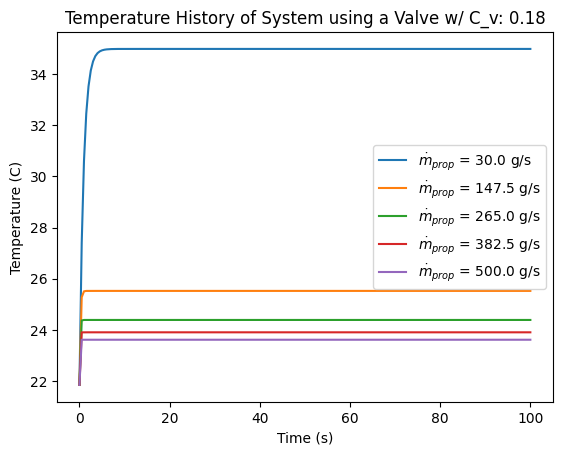

In [4]:
N_1 = 5
N_2 = 200
dt = 0.1

m_dot_array = np.linspace(0.03,0.5,N_1)

t_arrary = np.linspace(0,100, N_2)

T_history = np.zeros([N_1, N_2])

tau = 1

# For our systems thermal inertia, we will consider the volume in the volute of the impller + 30 cm 1/2 in line.
V = 20e-2 * np.pi * (10e-3/2)**2 + (np.pi * ((7e-2)/2)**2)*5e-3

cp = 2.68e3
rho = 786
rho_water = 1000
dp = 35e5

# Pump Parameters
m_dot_design = 0.8
eta_design = 0.3

N_1 = 8.65e-2
c_v = 0.37/2

Q = (N_1 * c_v * ((dp/1e3)/(rho/rho_water))**(1/2)) / (60*60)
m_dot_v = Q * rho

print(f"m_dot_v: {m_dot_v*1e3:.2f} g/s")
T_in = 295
T_o = T_in

for index, i in np.ndenumerate(m_dot_array):

    m_dot_draw = m_dot_array[index]

    tau = (V * rho) / (m_dot_v + m_dot_draw)

    chi = m_dot_draw/(m_dot_v + m_dot_draw)

    eta = ((m_dot_v + m_dot_draw)/m_dot_design) * eta_design

    print(eta)

    T_steady = T_in + (dp * (1 - eta))/(chi * rho * cp)

    temp_hist = T_steady + (T_o - T_steady)* np.exp(-chi*t_arrary/tau)

    plt.plot(t_arrary, temp_hist- 273.15, label=r"$\dot{m}_{prop}$ = " + f"{m_dot_draw*1e3:.1f} g/s")

plt.xlabel("Time (s)")
plt.ylabel("Temperature (C)")
plt.legend()
plt.title(f"Temperature History of System using a Valve w/ C_v: {c_v:.2f}")

We can now compare this to the expected vapour pressures of IPA as a function of temperature which was found [Here]([Here](https://en.wikipedia.org/wiki/Isopropyl_alcohol_%28data_page%29#/media/File:Isopropanol_Vapor_Pressure.tif))

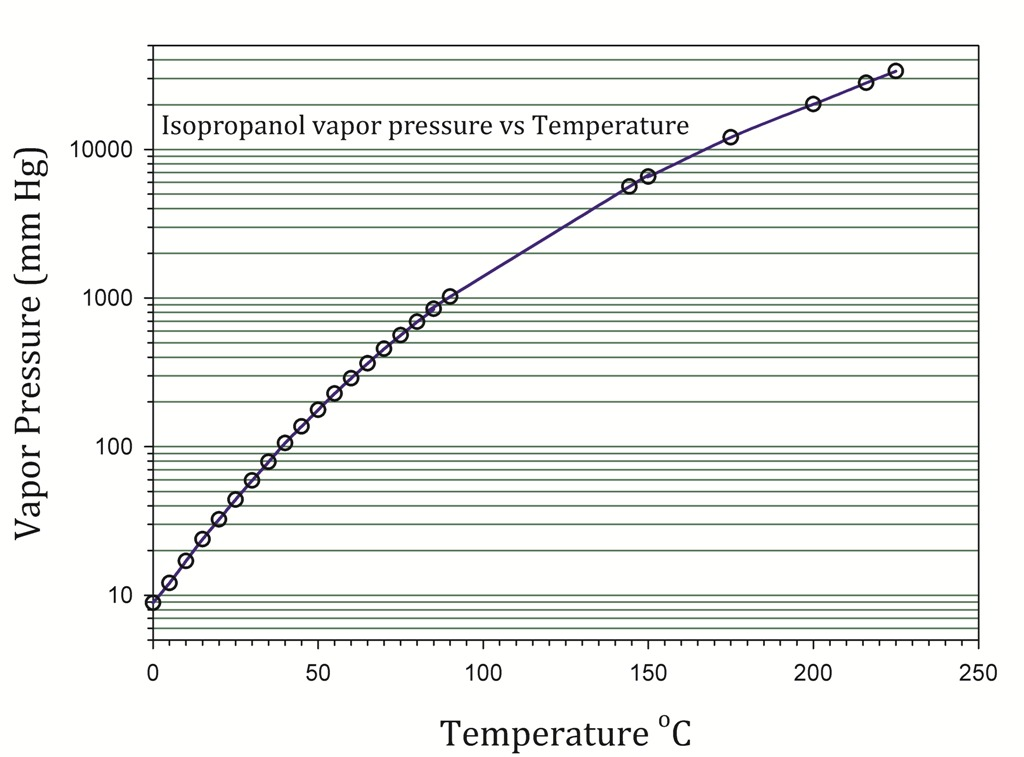

If we even take the value for 100 C, we can see that the vapour pressure ends up being 1000 mm Hg (1.33 Bar), which is way above the expected pressures we will be operating at. Hence this was considered acceptable.

### 2.2 - Required Performance Metrics

In [ ]:
pump_dic = {
    "dp": 25e5,
    "m_dot": 1.2,
    "N": 24e3 * (2*np.pi)/60
}

A definition of the IPA fluid has been presented below:

In [3]:
IPA = IncompressibleFluid(rho=787, P=20e5, mue=2.37e-3)

The following geometric parameters and performance assumptions have been used:

In [4]:
pump_geo = {
    "fluid": IPA,
    "l_1": 10e-3,
    "l_2": 5e-3,
    "v_0": 3,
    "v_3f": 0.61,
    "d_1f": 1.2,
    "a_3f": 3.5,
    "delta_div": 8,
    "diffuser_type": DiffuserType.rectangular,
    "psi": 0.2,
}

We can also evaluate for our specific speed of the pump to compare it to others of similar geometry

In [5]:
M3S_TO_GPM = 15850.323140625
g = 9.81
M_TO_FT = 3.28084

In [6]:
%%render

Q = (pump_dic["m_dot"]/pump_geo["fluid"].get_density()) * M3S_TO_GPM # gpm

H = pump_dic["dp"]/(pump_geo["fluid"].get_density() * g) * M_TO_FT # ft

N = pump_dic["N"] * 60/(2*np.pi) # rpm

N_s = (N * (Q) ** (1 / 2)) / H ** (0.75)

<IPython.core.display.Latex object>

## 3 - Calculated Geometry

Below a list of the key geometric parameters for the pump has been derived.

In [7]:
pump = Barske(**pump_dic)

pump.size_pump(**pump_geo)

,Eye Diameter - d_0 (mm),Inlet Diameter - d_1 (mm),Exit Diameter - d_2 (mm),Entrance Axial Blade Length - l_1 (mm),Exit Axial Blade Legnth - l_2 (mm),Axial Clearance - c_1 (mm),Radial Clearance - c_2 (mm),Diffuser Type,Diffuser Throat - d_3 (mm),Diffuser Exit - d_4 (mm),Diffuser Length - L (mm),Inlet Eye Velocity - v_o (m/s),Impeller Inlet Velocity - v_1 (m/s),Relative Exit Velocity - w_2 (m/s)
0,25.438863,30.526635,64.259317,10.0,5.0,0.642593,3.212966,DiffuserType.rectangular,6.190999,21.668495,110.12811,3,1.589929,1.510604


Finally, this is the expected performance metrics of the pump

In [8]:
performance = pump.get_pump_performance(fluid=pump_geo["fluid"], m_dot=pump_dic["m_dot"], psi=0.2, N=pump_dic["N"])

performance

,Head Rise (m),Head Rise (Bar),Efficiency (%),Hydraulic Power (kW),Required Shaft Power (kW)
0,323.814483,25.0,37.896204,3.811944,10.058907


## 4 - Transient Modelling

### 4.1 - Shut Down Transient 

In [12]:
%%render

T_pump = performance["Required Shaft Power (kW)"][0]*1e3/pump_dic["N"] # Nm

<IPython.core.display.Latex object>

We can thus use this value to roughly estiamte what our spin up and shut down times are.

We will use a factor of 4 to account for the transients

Based on the shaft analysis using `ROSS`, we can derive what our second moment of inertia is accordingly.

$$T = I \alpha$$

$$\alpha = \frac{T}{I}$$

In [13]:
%%render

I = 0.00105934

alpha = T_pump / I # rad/s

t = 4 * (pump_dic["N"]/ alpha)

<IPython.core.display.Latex object>

We can also do an iterative loop to see how it is considering the tail off

N = 2135.462268334717
t = 0.1
N = 1814.4455704141287
t = 0.2
N = 1541.68620856167
t = 0.30000000000000004
N = 1309.9298234263247
t = 0.4
N = 1113.0125785470973
t = 0.5
N = 945.6972257977857
t = 0.6
N = 803.5338145495933
t = 0.7
N = 682.7413399462381
t = 0.7999999999999999
N = 580.1071825867948
t = 0.8999999999999999
N = 492.9016650951416
t = 0.9999999999999999
N = 418.8054531064404
t = 1.0999999999999999
N = 355.8478698136167
t = 1.2
N = 302.35448347590153
t = 1.3
N = 256.9025739169426
t = 1.4000000000000001
N = 218.28329359108193
t = 1.5000000000000002
N = 185.4695168463944
t = 1.6000000000000003
N = 157.5885222974314
t = 1.7000000000000004
N = 133.89878176291168
t = 1.8000000000000005
N = 113.77023844257519
t = 1.9000000000000006
N = 96.66754980787772
t = 2.0000000000000004
N = 82.13584953129157
t = 2.1000000000000005
N = 69.78864977580298
t = 2.2000000000000006
N = 59.2975620916196
t = 2.3000000000000007
N = 50.383563535121056
t = 2.400000000000001
N = 42.80957572210784
t = 2.500000

Text(0.5, 0, 'Time(s)')

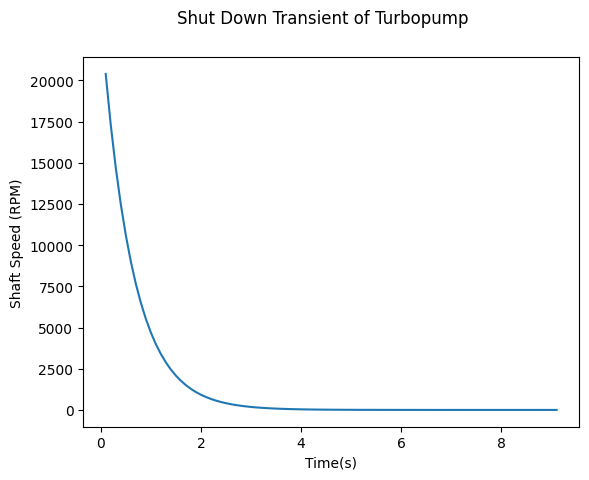

In [17]:
N_nom = pump_dic["N"]
T_nom = performance["Required Shaft Power (kW)"][0] * 1e3 / pump_dic["N"]

P_inlet = 30e5
P_dp_nom = pump_dic["dp"]

rho = 787

cda = 8.929216317561218e-07

I = 0.00105934

N = N_nom

dt = 0.1

t = 0

m_liq = 0

N_array = []

t_array = []

m_dot_array = []

m_liq_array = []

while N > 1e-3 :

    T_pump = T_nom * N/N_nom
    P_pump = P_dp_nom * N/N_nom

    alpha = T_pump / I
    dal = alpha*dt

    m_dot = cda * (2*rho*(P_pump+P_inlet-1e5))**(1/2)

    m_liq += m_dot*dt

    N -= dal

    t += dt

    print(f"N = {N}")
    print(f"t = {t}")

    N_array.append(N)
    t_array.append(t)
    m_dot_array.append(m_dot)
    m_liq_array.append(m_liq)


t_array = np.array(t_array)
N_array = np.array(N_array)
m_dot_array = np.array(m_dot_array)
m_liq_array = np.array(m_liq_array)

fig, ax = plt.subplots(nrows=1)

fig.suptitle(f"Shut Down Transient of Turbopump")
ax.plot(t_array, N_array * 60 / (2 * np.pi))

ax.set_ylabel("Shaft Speed (RPM)")

# ax[1].plot(t_array, m_liq_array * 1e3)

# ax[1].set_ylabel("IPA Dribble (g)")

ax.set_xlabel("Time(s)")

### 4.2 - Start-up Transient

We can do the same process just in reverse

N = 377.81185453711737
t = 0.1
N = 698.8285524577055
t = 0.2
N = 971.5879143101644
t = 0.30000000000000004
N = 1203.3442994455095
t = 0.4
N = 1400.2615443247369
t = 0.5
N = 1567.5768970740485
t = 0.6
N = 1709.740308322241
t = 0.7
N = 1830.5327829255962
t = 0.7999999999999999
N = 1933.1669402850396
t = 0.8999999999999999
N = 2020.3724577766927
t = 0.9999999999999999
N = 2094.4686697653938
t = 1.0999999999999999
N = 2157.4262530582178
t = 1.2
N = 2210.919639395933
t = 1.3
N = 2256.3715489548918
t = 1.4000000000000001
N = 2294.9908292807527
t = 1.5000000000000002
N = 2327.80460602544
t = 1.6000000000000003
N = 2355.685600574403
t = 1.7000000000000004
N = 2379.375341108923
t = 1.8000000000000005
N = 2399.5038844292594
t = 1.9000000000000006
N = 2416.606573063957
t = 2.0000000000000004
N = 2431.138273340543
t = 2.1000000000000005
N = 2443.4854730960315
t = 2.2000000000000006
N = 2453.9765607802146
t = 2.3000000000000007
N = 2462.890559336713
t = 2.400000000000001
N = 2470.4645471497265
t = 

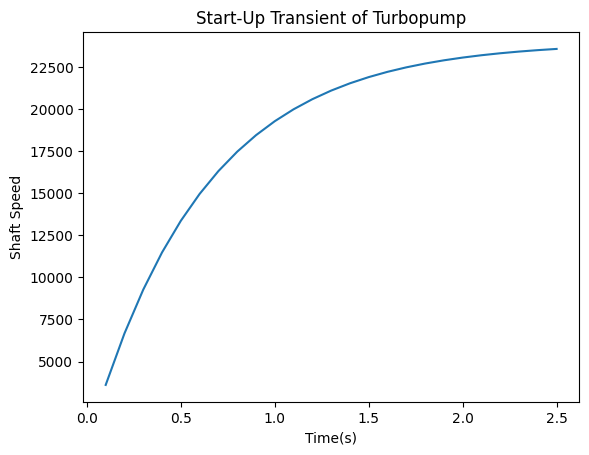

In [ ]:
N_nom = pump_dic["N"]
T_nom = performance["Required Shaft Power (kW)"][0] * 1e3 / pump_dic["N"]
I = 0.00105934

N = 0

dt = 0.1

t = 0

N_array = []

t_array = []

while N < 0.98*N_nom :

    T_pump = T_nom * N/N_nom

    T_total = T_nom - T_pump

    alpha = T_total / I

    dal = alpha*dt

    N += dal

    t += dt

    print(f"N = {N}")
    print(f"t = {t}")

    N_array.append(N)
    t_array.append(t)


t_array = np.array(t_array)
N_array = np.array(N_array)

plt.xlabel(f"Time(s)")
plt.ylabel(f"Shaft Speed")
plt.title(f"Start-Up Transient of Turbopump")
plt.plot(t_array, N_array * 60 / (2 * np.pi))

## 5 - Off Nominal Performance

The aim of this analysis is to see wher the turbopump performance varies as a function of pump performance

We will make a sensitivity where we vary the slip factor and accordinly vary the shaft speed to generate a set of power curves accordingly for the pump.

### 5.1 - Pump Performance

In [59]:
N1 = 100
N2 = 3

N_range = np.linspace(15e3, 40e3, N1)* 2*np.pi/60

psi_range = np.linspace(0.2, 0.6, N2)

N_range, psi_range = np.meshgrid(N_range, psi_range)


# We define our inlet fluid object and flow conditions:
IPA = IncompressibleFluid(rho=787, P=20e5, mue=2.37e-3)

m_dot = 1

# Head Rise Array

p_head_output = np.zeros([N2, N1])
p_shaft_array = np.zeros([N2, N1])


for index, value in np.ndenumerate(N_range):

    psi = psi_range[index]
    N = N_range[index]

    performance = pump.get_pump_performance(
        fluid=IPA, m_dot=m_dot, psi=psi, N=N
    )

    p_head_output[index] = performance["Head Rise (Bar)"][0]

    print(performance["Head Rise (Bar)"][0])
    p_shaft_array[index] = performance["Required Shaft Power (kW)"][0]

9.765625
10.097201674432313
10.43431385261141
10.77696153453729
11.125144720209956
11.478863409629401
11.83811760279563
12.202907299708643
12.57323250036844
12.94909320477502
13.330489412928381
13.717421124828535
14.10988834047546
14.507891059869172
14.911429283009662
15.320503009896953
15.73511224053101
16.15525697491186
16.580937213039483
17.012152954913887
17.44890420053509
17.891190949903073
18.33901320301783
18.792370959879378
19.251264220487705
19.71569298484281
20.185657252944715
20.661157024793376
21.142192300388842
21.62876307973109
22.120869362820113
22.618511149655927
23.121688440238536
23.63040123456789
24.14464953264406
24.66443333446701
25.189752640036716
25.72060744935324
26.256997762416546
26.798923579226596
27.346384899783466
27.899381724087103
28.457914052137536
29.021981883934746
29.591585219478723
30.166724058769507
30.74739840180706
31.333608248591403
31.925353599122538
32.522634453400435
33.12545081142512
33.73380267319662
34.34769003871486
34.96711290797989
35.59

We can now create our plot

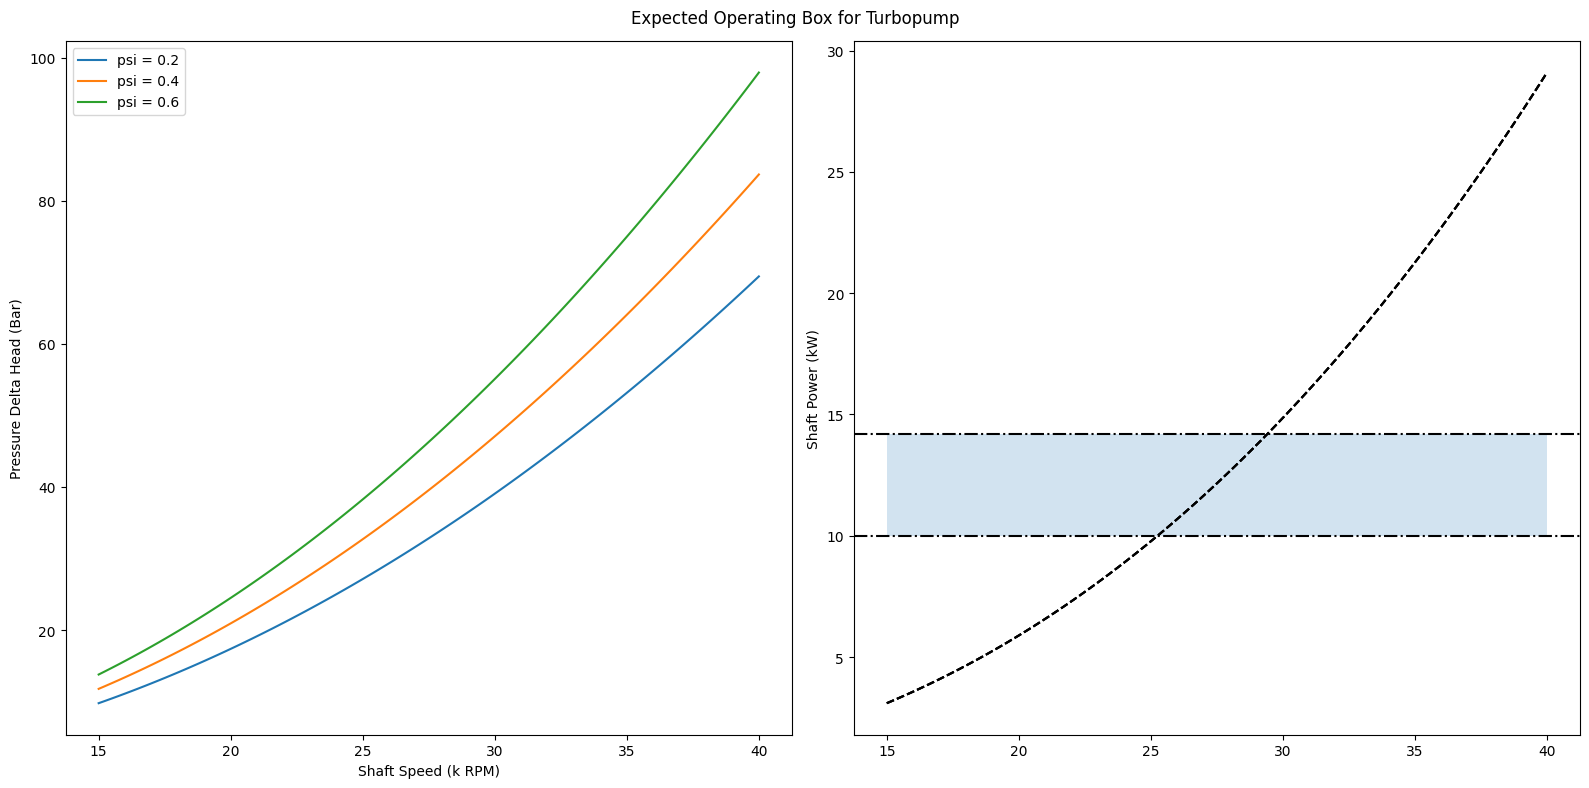

In [68]:
fig, ax = plt.subplots(ncols=2, figsize=(16,8))

ax2 = ax[1]
ax = ax[0]

for x in range(N2):
    ax.plot(N_range[x, :] * 60 / (2 * np.pi * 1e3), p_head_output[x, :], label=f"psi = {psi_range[x][0]}")

    ax2.plot(
        N_range[x, :] * 60 / (2 * np.pi * 1e3),
        p_shaft_array[x, :],
        label=f"psi = {psi_range[x][0]}",
        color="k",
        linestyle="--"
    )

ax2.axhline(10, color="k", linestyle="-.")
ax2.axhline(14.2, color="k", linestyle="-.")

ax2.fill_between(N_range[x, :] * 60 / (2 * np.pi * 1e3), 10, 14.2, alpha=0.2)

ax.legend()
ax.set_xlabel("Shaft Speed (k RPM)")
ax.set_ylabel("Pressure Delta Head (Bar)")
ax2.set_ylabel("Shaft Power (kW)")
fig.suptitle("Expected Operating Box for Turbopump")

plt.tight_layout()